In [9]:
import cv2 as cv
import numpy as np
import os

# You can replace this with hardcoded values if running directly in Jupyter Notebook
class Args:
    input = 'video.mp4'  # Replace with your video file path
    output = 'keypoints.npz'  # Replace with your desired output file path
    thr = 0.2
    width = 368
    height = 368

args = Args()

BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
              ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
              ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]]

HAND_PARTS = 22
FACE_PARTS = 70

# Load models
body_proto = "body/pose_deploy_linevec.prototxt"
body_model = "body/pose_iter_440000.caffemodel"
hand_proto = "hand/pose_deploy.prototxt"
hand_model = "hand/pose_iter_102000.caffemodel"
face_proto = "face/pose_deploy.prototxt"
face_model = "face/pose_iter_116000.caffemodel"

def check_file_exists(filepath):
    if os.path.isfile(filepath):
        print(f"Found: {filepath}")
    else:
        print(f"Not Found: {filepath}")
        raise FileNotFoundError(f"File not found: {filepath}")

check_file_exists(body_proto)
check_file_exists(body_model)
check_file_exists(hand_proto)
check_file_exists(hand_model)
check_file_exists(face_proto)
check_file_exists(face_model)

net_body = cv.dnn.readNetFromCaffe(body_proto, body_model)
net_hand = cv.dnn.readNetFromCaffe(hand_proto, hand_model)
net_face = cv.dnn.readNetFromCaffe(face_proto, face_model)

cap = cv.VideoCapture(args.input if args.input else 0)

keypoints_data = []

def get_keypoints(net, frame, width, height, threshold, num_parts):
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (width, height), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    points = []
    for i in range(num_parts):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frame.shape[1] * point[0]) / out.shape[3]
        y = (frame.shape[0] * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > threshold else None)
    return points

while True:
    hasFrame, frame = cap.read()
    if not hasFrame:
        break

    body_keypoints = get_keypoints(net_body, frame, args.width, args.height, args.thr, len(BODY_PARTS))
    hand_keypoints = get_keypoints(net_hand, frame, args.width, args.height, args.thr, HAND_PARTS)
    face_keypoints = get_keypoints(net_face, frame, args.width, args.height, args.thr, FACE_PARTS)

    keypoints_data.append({
        'body': body_keypoints,
        'hands': hand_keypoints,
        'face': face_keypoints
    })

    # Draw keypoints
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if body_keypoints[idFrom] and body_keypoints[idTo]:
            cv.line(frame, body_keypoints[idFrom], body_keypoints[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, body_keypoints[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, body_keypoints[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    for points in [hand_keypoints, face_keypoints]:
        for i, point in enumerate(points):
            if point:
                cv.ellipse(frame, point, (3, 3), 0, 0, 360, (255, 0, 0), cv.FILLED)

    t, _ = net_body.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('OpenPose using OpenCV', frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

# Save the keypoints to a file
np.savez(args.output, keypoints=keypoints_data)
print(f"Keypoints saved to {args.output}")


Found: body/pose_deploy_linevec.prototxt
Found: body/pose_iter_440000.caffemodel
Found: hand/pose_deploy.prototxt
Found: hand/pose_iter_102000.caffemodel
Found: face/pose_deploy.prototxt
Found: face/pose_iter_116000.caffemodel
Keypoints saved to keypoints.npz


On dataset using open CV

In [10]:
%pip install tqdm


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
%pip install joblib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import cv2 as cv
import numpy as np
import os
from tqdm import tqdm
from joblib import Parallel, delayed

# Directory structure configuration
dataset_dir = 'wlasldaily'
output_dir = 'keypoints_output'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
              ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
              ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]]

HAND_PARTS = 22
FACE_PARTS = 70

# Model paths
body_proto = "body/pose_deploy_linevec.prototxt"
body_model = "body/pose_iter_440000.caffemodel"
hand_proto = "hand/pose_deploy.prototxt"
hand_model = "hand/pose_iter_102000.caffemodel"
face_proto = "face/pose_deploy.prototxt"
face_model = "face/pose_iter_116000.caffemodel"

def check_file_exists(filepath):
    if os.path.isfile(filepath):
        print(f"Found: {filepath}")
    else:
        print(f"Not Found: {filepath}")
        raise FileNotFoundError(f"File not found: {filepath}")

check_file_exists(body_proto)
check_file_exists(body_model)
check_file_exists(hand_proto)
check_file_exists(hand_model)
check_file_exists(face_proto)
check_file_exists(face_model)

def get_keypoints(net, frame, width, height, threshold, num_parts):
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (width, height), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    points = []
    for i in range(num_parts):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frame.shape[1] * point[0]) / out.shape[3]
        y = (frame.shape[0] * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > threshold else None)
    return points

def process_video(video_path, output_path, width=368, height=368, threshold=0.2, fps=5):
    # Load models within the function to avoid pickling issues
    net_body = cv.dnn.readNetFromCaffe(body_proto, body_model)
    net_hand = cv.dnn.readNetFromCaffe(hand_proto, hand_model)
    net_face = cv.dnn.readNetFromCaffe(face_proto, face_model)

    cap = cv.VideoCapture(video_path)
    keypoints_data = []
    frame_count = 0
    frame_rate = cap.get(cv.CAP_PROP_FPS)
    sample_rate = int(frame_rate / fps)

    while True:
        hasFrame, frame = cap.read()
        if not hasFrame:
            break

        if frame_count % sample_rate == 0:
            body_keypoints = get_keypoints(net_body, frame, width, height, threshold, len(BODY_PARTS))
            hand_keypoints = get_keypoints(net_hand, frame, width, height, threshold, HAND_PARTS)
            face_keypoints = get_keypoints(net_face, frame, width, height, threshold, FACE_PARTS)

            keypoints_data.append({
                'body': body_keypoints,
                'hands': hand_keypoints,
                'face': face_keypoints
            })
        
        frame_count += 1

    cap.release()
    
    # Save the keypoints to a file
    np.savez(output_path, keypoints=keypoints_data)
    print(f"Keypoints saved to {output_path}")

def process_class_videos(class_name):
    class_dir = os.path.join(dataset_dir, class_name)
    output_class_dir = os.path.join(output_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)
    
    for video_name in tqdm(os.listdir(class_dir), desc=f'Processing {class_name}', leave=False):
        video_path = os.path.join(class_dir, video_name)
        output_path = os.path.join(output_class_dir, os.path.splitext(video_name)[0] + '.npz')
        process_video(video_path, output_path)

# Iterate over the dataset directory
Parallel(n_jobs=-1)(delayed(process_class_videos)(class_name) for class_name in tqdm(os.listdir(dataset_dir), desc='Classes'))


Found: body/pose_deploy_linevec.prototxt
Found: body/pose_iter_440000.caffemodel
Found: hand/pose_deploy.prototxt
Found: hand/pose_iter_102000.caffemodel
Found: face/pose_deploy.prototxt
Found: face/pose_iter_116000.caffemodel


Classes:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np

def move_files(file_list, src_dir, dst_dir, file_ext):
    for file_name in file_list:
        base_name, _ = os.path.splitext(file_name)
        src_file = os.path.join(src_dir, base_name + file_ext)
        dst_file = os.path.join(dst_dir, base_name + file_ext)
        shutil.copy(src_file, dst_file)

def split_dataset(video_dir, keypoints_dir, output_video_dir, output_keypoints_dir, train_ratio=0.7, val_ratio=0.15):
    # Ensure the output directories exist
    os.makedirs(output_video_dir, exist_ok=True)
    os.makedirs(output_keypoints_dir, exist_ok=True)
    
    class_names = os.listdir(video_dir)
    
    for class_name in class_names:
        video_class_dir = os.path.join(video_dir, class_name)
        keypoints_class_dir = os.path.join(keypoints_dir, class_name)
        videos = os.listdir(video_class_dir)
        
        # Split videos into train, val, and test sets
        train_videos, test_videos = train_test_split(videos, test_size=1 - train_ratio)
        val_videos, test_videos = train_test_split(test_videos, test_size=val_ratio / (1 - train_ratio))
        
        # Create output directories for the class
        train_video_dir = os.path.join(output_video_dir, 'train', class_name)
        val_video_dir = os.path.join(output_video_dir, 'val', class_name)
        test_video_dir = os.path.join(output_video_dir, 'test', class_name)
        train_keypoints_dir = os.path.join(output_keypoints_dir, 'train', class_name)
        val_keypoints_dir = os.path.join(output_keypoints_dir, 'val', class_name)
        test_keypoints_dir = os.path.join(output_keypoints_dir, 'test', class_name)
        
        os.makedirs(train_video_dir, exist_ok=True)
        os.makedirs(val_video_dir, exist_ok=True)
        os.makedirs(test_video_dir, exist_ok=True)
        os.makedirs(train_keypoints_dir, exist_ok=True)
        os.makedirs(val_keypoints_dir, exist_ok=True)
        os.makedirs(test_keypoints_dir, exist_ok=True)
        
        # Move video files
        move_files(train_videos, video_class_dir, train_video_dir, '.mp4')
        move_files(val_videos, video_class_dir, val_video_dir, '.mp4')
        move_files(test_videos, video_class_dir, test_video_dir, '.mp4')
        
        # Move keypoints files
        move_files(train_videos, keypoints_class_dir, train_keypoints_dir, '.npz')
        move_files(val_videos, keypoints_class_dir, val_keypoints_dir, '.npz')
        move_files(test_videos, keypoints_class_dir, test_keypoints_dir, '.npz')

# Usage
video_dir = 'wlasldaily'
keypoints_dir = 'keypoints_output'
output_video_dir = 'split_videos'
output_keypoints_dir = 'split_keypoints'

split_dataset(video_dir, keypoints_dir, output_video_dir, output_keypoints_dir)


Preprocess

In [10]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

def extract_keypoints(data):
    # Extracts keypoints from the dictionary format to a flat list
    keypoints = []
    for frame in data:
        frame_keypoints = []
        for part in frame['body']:
            if part is not None:
                frame_keypoints.extend([part[0], part[1], part[2] if len(part) > 2 else 1])
            else:
                frame_keypoints.extend([0, 0, 0])
        keypoints.append(frame_keypoints)
    return keypoints

def load_data(base_dir, class_names, max_len):
    X, y = [], []
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.npz'):
                file_path = os.path.join(class_dir, file_name)
                data = np.load(file_path, allow_pickle=True)['keypoints']
                keypoints = extract_keypoints(data)
                X.append(keypoints)
                y.append(class_index)
    
    # Pad sequences to the same length
    X = pad_sequences(X, maxlen=max_len, padding='post', dtype='float32')
    y = np.array(y)
    y = to_categorical(y, num_classes=len(class_names))
    return np.array(X), y

train_dir = 'split_keypoints/train'
val_dir = 'split_keypoints/val'
test_dir = 'split_keypoints/test'

class_names = os.listdir(train_dir)

# Determine the maximum sequence length
max_len = 0
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.npz'):
            file_path = os.path.join(class_dir, file_name)
            data = np.load(file_path, allow_pickle=True)['keypoints']
            if len(data) > max_len:
                max_len = len(data)

X_train, y_train = load_data(train_dir, class_names, max_len)
X_val, y_val = load_data(val_dir, class_names, max_len)
X_test, y_test = load_data(test_dir, class_names, max_len)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (242, 61, 57), (242, 13)
Validation data shape: (57, 61, 57), (57, 13)
Test data shape: (60, 61, 57), (60, 13)


CNN and LSTM start below

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 61, 1, 57, 64)    640       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 61, 1, 29, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 61, 1, 29, 128)   73856     
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 61, 1, 15, 128)   0         
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 61, 1, 15, 256)  

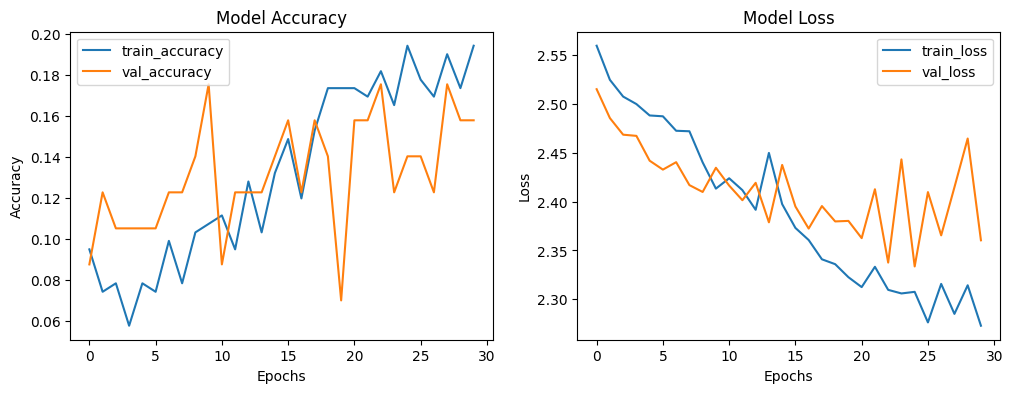

2/2 [==============================] - 2s 549ms/step


ValueError: Number of classes, 12, does not match size of target_names, 13. Try specifying the labels parameter

In [15]:
from tensorflow.keras.optimizers import Adam

def create_cnn_lstm_model(input_shape, num_classes):
    model = models.Sequential()
    
    # CNN layers within TimeDistributed
    model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding='same')))
    model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding='same')))
    model.add(layers.TimeDistributed(layers.Conv2D(256, (3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding='same')))
    model.add(layers.TimeDistributed(layers.Conv2D(512, (3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding='same')))
    
    model.add(layers.TimeDistributed(layers.Flatten()))
    model.add(layers.TimeDistributed(layers.Dense(256, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dropout(0.5)))
    model.add(layers.TimeDistributed(layers.Dense(128, activation='relu')))
    
    # LSTM layers
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(64))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

input_shape = (num_frames, height, width, channels)
num_classes = len(class_names)

model = create_cnn_lstm_model(input_shape, num_classes)

# Adjusted learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Define a callback to save the model after every epoch
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("6julmodel_epoch_{epoch:02d}.h5", save_best_only=False)

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=8, callbacks=[checkpoint_cb])

# Evaluating the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Plotting accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predicting the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generating the classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute precision, recall, F1-score
report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

2nd code 

Training data shape: (242, 61, 57), (242, 13)
Validation data shape: (57, 61, 57), (57, 13)
Test data shape: (60, 61, 57), (60, 13)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 61, 1, 57, 32)    320       
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 61, 1, 29, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 61, 1, 29, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 61, 1, 15, 64)    0         
 stributed)                                           

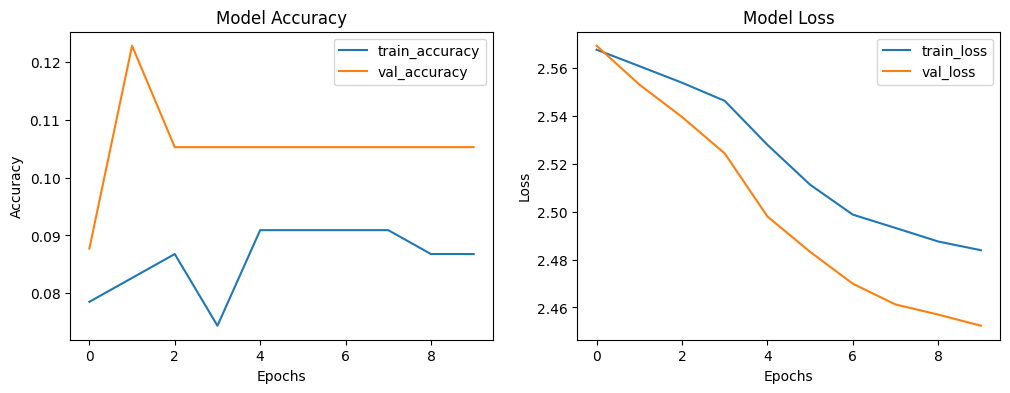

2/2 [==============================] - 1s 83ms/step


ValueError: Number of classes, 12, does not match size of target_names, 13. Try specifying the labels parameter

In [16]:
import cv2 as cv
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Assuming keypoint extraction functions and models are defined here

# Function to extract keypoints from a single video file
def extract_keypoints_from_video(video_path):
    cap = cv.VideoCapture(video_path)
    keypoints_data = []

    while True:
        hasFrame, frame = cap.read()
        if not hasFrame:
            break

        body_keypoints = get_keypoints(net_body, frame, 368, 368, 0.2, len(BODY_PARTS))
        hand_keypoints = get_keypoints(net_hand, frame, 368, 368, 0.2, HAND_PARTS)
        face_keypoints = get_keypoints(net_face, frame, 368, 368, 0.2, FACE_PARTS)

        keypoints_data.append({
            'body': body_keypoints,
            'hands': hand_keypoints,
            'face': face_keypoints
        })

    cap.release()
    return keypoints_data

# Ensure the keypoints extraction function is consistent
def extract_keypoints(data):
    keypoints = []
    for frame in data:
        frame_keypoints = []
        for part in frame['body']:
            if part is not None:
                frame_keypoints.extend([part[0], part[1], part[2] if len(part) > 2 else 1])
            else:
                frame_keypoints.extend([0, 0, 0])
        keypoints.append(frame_keypoints)
    return keypoints

def load_data(base_dir, class_names, max_len):
    X, y = [], []
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.npz'):
                file_path = os.path.join(class_dir, file_name)
                data = np.load(file_path, allow_pickle=True)['keypoints']
                keypoints = extract_keypoints(data)
                X.append(keypoints)
                y.append(class_index)
    
    # Pad sequences to the same length
    X = pad_sequences(X, maxlen=max_len, padding='post', dtype='float32')
    y = np.array(y)
    y = to_categorical(y, num_classes=len(class_names))
    return np.array(X), y

# Simplified model architecture for debugging
def create_simple_cnn_lstm_model(input_shape, num_classes):
    model = models.Sequential()
    
    model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding='same')))
    
    model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding='same')))
    
    model.add(layers.TimeDistributed(layers.Flatten()))
    model.add(layers.TimeDistributed(layers.Dense(128, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dropout(0.5)))
    
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(64))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Main script
train_dir = 'split_keypoints/train'
val_dir = 'split_keypoints/val'
test_dir = 'split_keypoints/test'

class_names = os.listdir(train_dir)

# Determine the maximum sequence length
max_len = 0
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.npz'):
            file_path = os.path.join(class_dir, file_name)
            data = np.load(file_path, allow_pickle=True)['keypoints']
            if len(data) > max_len:
                max_len = len(data)

X_train, y_train = load_data(train_dir, class_names, max_len)
X_val, y_val = load_data(val_dir, class_names, max_len)
X_test, y_test = load_data(test_dir, class_names, max_len)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

# Define the input shape
num_frames = X_train.shape[1]
num_keypoints = X_train.shape[2] // 3  # Assuming each keypoint has 3 values (x, y, confidence)
height = 1
width = num_keypoints * 3
channels = 1

input_shape = (num_frames, height, width, channels)
num_classes = len(class_names)

model = create_simple_cnn_lstm_model(input_shape, num_classes)

# Adjust the learning rate
learning_rate = 0.0001  # Try a lower learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Define a callback to save the model after every epoch
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_epoch_{epoch:02d}.h5", save_best_only=False)

# Reshape your data to the shape (num_samples, num_frames, height, width, channels)
X_train = X_train.reshape((X_train.shape[0], num_frames, height, width, channels))
X_val = X_val.reshape((X_val.shape[0], num_frames, height, width, channels))
X_test = X_test.reshape((X_test.shape[0], num_frames, height, width, channels))

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8, callbacks=[checkpoint_cb])

# Evaluating the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Plotting accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predicting the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generating the classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute precision, recall, F1-score
report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


3rd Try

In [17]:
import cv2 as cv
import numpy as np
import os
from tqdm import tqdm
from joblib import Parallel, delayed

# Directory structure configuration
dataset_dir = 'split_videos'
output_dir = 'keypoints_output'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

HAND_PARTS = 22
FACE_PARTS = 70

# Model paths
body_proto = "body/pose_deploy_linevec.prototxt"
body_model = "body/pose_iter_440000.caffemodel"
hand_proto = "hand/pose_deploy.prototxt"
hand_model = "hand/pose_iter_102000.caffemodel"
face_proto = "face/pose_deploy.prototxt"
face_model = "face/pose_iter_116000.caffemodel"

def check_file_exists(filepath):
    if os.path.isfile(filepath):
        print(f"Found: {filepath}")
    else:
        print(f"Not Found: {filepath}")
        raise FileNotFoundError(f"File not found: {filepath}")

check_file_exists(body_proto)
check_file_exists(body_model)
check_file_exists(hand_proto)
check_file_exists(hand_model)
check_file_exists(face_proto)
check_file_exists(face_model)

def get_keypoints(net, frame, width, height, threshold, num_parts):
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (width, height), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    points = []
    for i in range(num_parts):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frame.shape[1] * point[0]) / out.shape[3]
        y = (frame.shape[0] * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > threshold else None)
    return points

def process_video(video_path, output_path, width=368, height=368, threshold=0.2, fps=5):
    # Load models within the function to avoid pickling issues
    net_body = cv.dnn.readNetFromCaffe(body_proto, body_model)
    net_hand = cv.dnn.readNetFromCaffe(hand_proto, hand_model)
    net_face = cv.dnn.readNetFromCaffe(face_proto, face_model)

    cap = cv.VideoCapture(video_path)
    keypoints_data = []
    frame_count = 0
    frame_rate = cap.get(cv.CAP_PROP_FPS)
    sample_rate = int(frame_rate / fps)

    while True:
        hasFrame, frame = cap.read()
        if not hasFrame:
            break

        if frame_count % sample_rate == 0:
            body_keypoints = get_keypoints(net_body, frame, width, height, threshold, len(BODY_PARTS))
            hand_keypoints = get_keypoints(net_hand, frame, width, height, threshold, HAND_PARTS)
            face_keypoints = get_keypoints(net_face, frame, width, height, threshold, FACE_PARTS)

            keypoints_data.append({
                'body': body_keypoints,
                'hands': hand_keypoints,
                'face': face_keypoints
            })
        
        frame_count += 1

    cap.release()
    
    # Save the keypoints to a file
    np.savez(output_path, keypoints=keypoints_data)
    print(f"Keypoints saved to {output_path}")

def process_batch(class_names):
    for class_name in class_names:
        class_dir = os.path.join(dataset_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        for video_name in tqdm(os.listdir(class_dir), desc=f'Processing {class_name}', leave=False):
            video_path = os.path.join(class_dir, video_name)
            output_path = os.path.join(output_class_dir, os.path.splitext(video_name)[0] + '.npz')
            process_video(video_path, output_path)

# Get the list of class names
class_names = os.listdir(dataset_dir)

# Define batch size
batch_size = 5

# Process classes in batches
for i in range(0, len(class_names), batch_size):
    batch = class_names[i:i + batch_size]
    process_batch(batch)


Found: body/pose_deploy_linevec.prototxt
Found: body/pose_iter_440000.caffemodel
Found: hand/pose_deploy.prototxt
Found: hand/pose_iter_102000.caffemodel
Found: face/pose_deploy.prototxt
Found: face/pose_iter_116000.caffemodel


Processing test:   8%|▊         | 1/12 [00:02<00:32,  2.95s/it]

Keypoints saved to keypoints_output\test\deaf.npz


Processing test:  17%|█▋        | 2/12 [00:04<00:22,  2.24s/it]

Keypoints saved to keypoints_output\test\drink.npz


Processing test:  25%|██▌       | 3/12 [00:06<00:17,  1.94s/it]

Keypoints saved to keypoints_output\test\fine.npz


Processing test:  33%|███▎      | 4/12 [00:07<00:14,  1.82s/it]

Keypoints saved to keypoints_output\test\food.npz


Processing test:  42%|████▏     | 5/12 [00:09<00:12,  1.75s/it]

Keypoints saved to keypoints_output\test\go.npz


Processing test:  50%|█████     | 6/12 [00:11<00:10,  1.70s/it]

Keypoints saved to keypoints_output\test\hello.npz


Processing test:  58%|█████▊    | 7/12 [00:12<00:08,  1.68s/it]

Keypoints saved to keypoints_output\test\help.npz


Processing test:  67%|██████▋   | 8/12 [00:14<00:06,  1.65s/it]

Keypoints saved to keypoints_output\test\name.npz


Processing test:  75%|███████▌  | 9/12 [00:15<00:04,  1.63s/it]

Keypoints saved to keypoints_output\test\need.npz


Processing test:  83%|████████▎ | 10/12 [00:17<00:03,  1.64s/it]

Keypoints saved to keypoints_output\test\no.npz


Processing test:  92%|█████████▏| 11/12 [00:19<00:01,  1.62s/it]

Keypoints saved to keypoints_output\test\sick.npz


Keypoints saved to keypoints_output\test\sorry.npz


Processing train:   8%|▊         | 1/12 [00:01<00:17,  1.60s/it]

Keypoints saved to keypoints_output\train\deaf.npz


Processing train:  17%|█▋        | 2/12 [00:03<00:15,  1.58s/it]

Keypoints saved to keypoints_output\train\drink.npz


Processing train:  25%|██▌       | 3/12 [00:04<00:15,  1.67s/it]

Keypoints saved to keypoints_output\train\fine.npz


Processing train:  33%|███▎      | 4/12 [00:06<00:13,  1.66s/it]

Keypoints saved to keypoints_output\train\food.npz


Processing train:  42%|████▏     | 5/12 [00:08<00:11,  1.66s/it]

Keypoints saved to keypoints_output\train\go.npz


Processing train:  50%|█████     | 6/12 [00:09<00:09,  1.63s/it]

Keypoints saved to keypoints_output\train\hello.npz


Processing train:  58%|█████▊    | 7/12 [00:11<00:08,  1.61s/it]

Keypoints saved to keypoints_output\train\help.npz


Processing train:  67%|██████▋   | 8/12 [00:13<00:06,  1.62s/it]

Keypoints saved to keypoints_output\train\name.npz


Processing train:  75%|███████▌  | 9/12 [00:14<00:04,  1.61s/it]

Keypoints saved to keypoints_output\train\need.npz


Processing train:  83%|████████▎ | 10/12 [00:16<00:03,  1.66s/it]

Keypoints saved to keypoints_output\train\no.npz


Processing train:  92%|█████████▏| 11/12 [00:18<00:01,  1.69s/it]

Keypoints saved to keypoints_output\train\sick.npz


Keypoints saved to keypoints_output\train\sorry.npz


Processing val:   8%|▊         | 1/12 [00:01<00:18,  1.65s/it]

Keypoints saved to keypoints_output\val\deaf.npz


Processing val:  17%|█▋        | 2/12 [00:03<00:15,  1.59s/it]

Keypoints saved to keypoints_output\val\drink.npz


Processing val:  25%|██▌       | 3/12 [00:04<00:14,  1.59s/it]

Keypoints saved to keypoints_output\val\fine.npz


Processing val:  33%|███▎      | 4/12 [00:06<00:12,  1.58s/it]

Keypoints saved to keypoints_output\val\food.npz


Processing val:  42%|████▏     | 5/12 [00:07<00:11,  1.58s/it]

Keypoints saved to keypoints_output\val\go.npz


Processing val:  50%|█████     | 6/12 [00:09<00:09,  1.57s/it]

Keypoints saved to keypoints_output\val\hello.npz


Processing val:  58%|█████▊    | 7/12 [00:11<00:08,  1.68s/it]

Keypoints saved to keypoints_output\val\help.npz


Processing val:  67%|██████▋   | 8/12 [00:13<00:06,  1.68s/it]

Keypoints saved to keypoints_output\val\name.npz


Processing val:  75%|███████▌  | 9/12 [00:14<00:05,  1.68s/it]

Keypoints saved to keypoints_output\val\need.npz


Processing val:  83%|████████▎ | 10/12 [00:16<00:03,  1.70s/it]

Keypoints saved to keypoints_output\val\no.npz


Processing val:  92%|█████████▏| 11/12 [00:18<00:01,  1.73s/it]

Keypoints saved to keypoints_output\val\sick.npz


Keypoints saved to keypoints_output\val\sorry.npz


In [18]:
def process_batch(class_names):
    for class_name in class_names:
        class_dir = os.path.join(dataset_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        for video_name in tqdm(os.listdir(class_dir), desc=f'Processing {class_name}', leave=False):
            video_path = os.path.join(class_dir, video_name)
            output_path = os.path.join(output_class_dir, os.path.splitext(video_name)[0] + '.npz')
            process_video(video_path, output_path)

# Get the list of class names
class_names = os.listdir(dataset_dir)

# Define batch size
batch_size = 5

# Process classes in batches
for i in range(0, len(class_names), batch_size):
    batch = class_names[i:i + batch_size]
    process_batch(batch)


Processing test:   8%|▊         | 1/12 [00:01<00:19,  1.75s/it]

Keypoints saved to keypoints_output\test\deaf.npz


Processing test:  17%|█▋        | 2/12 [00:03<00:16,  1.66s/it]

Keypoints saved to keypoints_output\test\drink.npz


Processing test:  25%|██▌       | 3/12 [00:04<00:14,  1.63s/it]

Keypoints saved to keypoints_output\test\fine.npz


Processing test:  33%|███▎      | 4/12 [00:06<00:13,  1.65s/it]

Keypoints saved to keypoints_output\test\food.npz


Processing test:  42%|████▏     | 5/12 [00:08<00:11,  1.64s/it]

Keypoints saved to keypoints_output\test\go.npz


Processing test:  50%|█████     | 6/12 [00:09<00:09,  1.62s/it]

Keypoints saved to keypoints_output\test\hello.npz


Processing test:  58%|█████▊    | 7/12 [00:11<00:08,  1.65s/it]

Keypoints saved to keypoints_output\test\help.npz


Processing test:  67%|██████▋   | 8/12 [00:13<00:06,  1.63s/it]

Keypoints saved to keypoints_output\test\name.npz


Processing test:  75%|███████▌  | 9/12 [00:14<00:04,  1.61s/it]

Keypoints saved to keypoints_output\test\need.npz


Processing test:  83%|████████▎ | 10/12 [00:16<00:03,  1.63s/it]

Keypoints saved to keypoints_output\test\no.npz


Processing test:  92%|█████████▏| 11/12 [00:17<00:01,  1.62s/it]

Keypoints saved to keypoints_output\test\sick.npz


Keypoints saved to keypoints_output\test\sorry.npz


Processing train:   8%|▊         | 1/12 [00:02<00:22,  2.00s/it]

Keypoints saved to keypoints_output\train\deaf.npz


Processing train:  17%|█▋        | 2/12 [00:03<00:18,  1.81s/it]

Keypoints saved to keypoints_output\train\drink.npz


Processing train:  25%|██▌       | 3/12 [00:05<00:15,  1.77s/it]

Keypoints saved to keypoints_output\train\fine.npz


Processing train:  33%|███▎      | 4/12 [00:07<00:14,  1.86s/it]

Keypoints saved to keypoints_output\train\food.npz


Processing train:  42%|████▏     | 5/12 [00:09<00:12,  1.85s/it]

Keypoints saved to keypoints_output\train\go.npz


Processing train:  50%|█████     | 6/12 [00:11<00:10,  1.83s/it]

Keypoints saved to keypoints_output\train\hello.npz


Processing train:  58%|█████▊    | 7/12 [00:12<00:08,  1.77s/it]

Keypoints saved to keypoints_output\train\help.npz


Processing train:  67%|██████▋   | 8/12 [00:14<00:06,  1.74s/it]

Keypoints saved to keypoints_output\train\name.npz


Processing train:  75%|███████▌  | 9/12 [00:16<00:05,  1.77s/it]

Keypoints saved to keypoints_output\train\need.npz


Processing train:  83%|████████▎ | 10/12 [00:18<00:03,  1.85s/it]

Keypoints saved to keypoints_output\train\no.npz


Processing train:  92%|█████████▏| 11/12 [00:20<00:01,  1.88s/it]

Keypoints saved to keypoints_output\train\sick.npz


Keypoints saved to keypoints_output\train\sorry.npz


Processing val:   8%|▊         | 1/12 [00:01<00:18,  1.65s/it]

Keypoints saved to keypoints_output\val\deaf.npz


Processing val:  17%|█▋        | 2/12 [00:03<00:16,  1.65s/it]

Keypoints saved to keypoints_output\val\drink.npz


Processing val:  25%|██▌       | 3/12 [00:04<00:14,  1.64s/it]

Keypoints saved to keypoints_output\val\fine.npz


Processing val:  33%|███▎      | 4/12 [00:06<00:13,  1.64s/it]

Keypoints saved to keypoints_output\val\food.npz


Processing val:  42%|████▏     | 5/12 [00:08<00:11,  1.68s/it]

Keypoints saved to keypoints_output\val\go.npz


Processing val:  50%|█████     | 6/12 [00:10<00:10,  1.68s/it]

Keypoints saved to keypoints_output\val\hello.npz


Processing val:  58%|█████▊    | 7/12 [00:11<00:08,  1.67s/it]

Keypoints saved to keypoints_output\val\help.npz


Processing val:  67%|██████▋   | 8/12 [00:13<00:06,  1.70s/it]

Keypoints saved to keypoints_output\val\name.npz


Processing val:  75%|███████▌  | 9/12 [00:15<00:05,  1.69s/it]

Keypoints saved to keypoints_output\val\need.npz


Processing val:  83%|████████▎ | 10/12 [00:17<00:03,  1.80s/it]

Keypoints saved to keypoints_output\val\no.npz


Processing val:  92%|█████████▏| 11/12 [00:18<00:01,  1.78s/it]

Keypoints saved to keypoints_output\val\sick.npz


Keypoints saved to keypoints_output\val\sorry.npz


In [22]:
import cv2 as cv
import numpy as np
import os
from tqdm import tqdm

# Directory structure configuration
dataset_dir = 'split_videos'
output_dir = 'keypoints_output'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

HAND_PARTS = 22
FACE_PARTS = 70

# Model paths
body_proto = "body/pose_deploy_linevec.prototxt"
body_model = "body/pose_iter_440000.caffemodel"
hand_proto = "hand/pose_deploy.prototxt"
hand_model = "hand/pose_iter_102000.caffemodel"
face_proto = "face/pose_deploy.prototxt"
face_model = "face/pose_iter_116000.caffemodel"

def check_file_exists(filepath):
    if os.path.isfile(filepath):
        print(f"Found: {filepath}")
    else:
        print(f"Not Found: {filepath}")
        raise FileNotFoundError(f"File not found: {filepath}")

check_file_exists(body_proto)
check_file_exists(body_model)
check_file_exists(hand_proto)
check_file_exists(hand_model)
check_file_exists(face_proto)
check_file_exists(face_model)

def get_keypoints(net, frame, width, height, threshold, num_parts):
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (width, height), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    points = []
    for i in range(num_parts):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frame.shape[1] * point[0]) / out.shape[3]
        y = (frame.shape[0] * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > threshold else None)
    return points

def process_video(video_path, output_path, width=368, height=368, threshold=0.2, fps=5):
    # Load models within the function to avoid pickling issues
    net_body = cv.dnn.readNetFromCaffe(body_proto, body_model)
    net_hand = cv.dnn.readNetFromCaffe(hand_proto, hand_model)
    net_face = cv.dnn.readNetFromCaffe(face_proto, face_model)

    cap = cv.VideoCapture(video_path)
    keypoints_data = []
    frame_count = 0
    frame_rate = cap.get(cv.CAP_PROP_FPS)
    sample_rate = int(frame_rate / fps)

    while True:
        hasFrame, frame = cap.read()
        if not hasFrame:
            break

        if frame_count % sample_rate == 0:
            body_keypoints = get_keypoints(net_body, frame, width, height, threshold, len(BODY_PARTS))
            hand_keypoints = get_keypoints(net_hand, frame, width, height, threshold, HAND_PARTS)
            face_keypoints = get_keypoints(net_face, frame, width, height, threshold, FACE_PARTS)

            keypoints_data.append({
                'body': body_keypoints,
                'hands': hand_keypoints,
                'face': face_keypoints
            })
        
        frame_count += 1

    cap.release()
    
    # Save the keypoints to a file
    np.savez(output_path, keypoints=keypoints_data)
    print(f"Keypoints saved to {output_path}")

def process_directory(dataset_subdir):
    dataset_path = os.path.join(dataset_dir, dataset_subdir)
    output_path = os.path.join(output_dir, dataset_subdir)
    os.makedirs(output_path, exist_ok=True)
    
    class_names = os.listdir(dataset_path)
    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        output_class_dir = os.path.join(output_path, class_name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        for video_name in tqdm(os.listdir(class_dir), desc=f'Processing {class_name} in {dataset_subdir}', leave=False):
            video_path = os.path.join(class_dir, video_name)
            output_file_path = os.path.join(output_class_dir, os.path.splitext(video_name)[0] + '.npz')
            process_video(video_path, output_file_path)

# Process train, val, and test directories
for subdir in ['train', 'val', 'test']:
    process_directory(subdir)





#CNN AND LSTM 

import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def extract_keypoints(data):
    keypoints = []
    for frame in data:
        frame_keypoints = []
        for part in frame['body']:
            if part is not None:
                frame_keypoints.extend([part[0], part[1], part[2] if len(part) > 2 else 1])
            else:
                frame_keypoints.extend([0, 0, 0])
        keypoints.append(frame_keypoints)
    return keypoints

def load_data(base_dir, class_names, max_len):
    X, y = [], []
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):  # Ensure it's a directory
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.npz'):
                    file_path = os.path.join(class_dir, file_name)
                    data = np.load(file_path, allow_pickle=True)['keypoints']
                    keypoints = extract_keypoints(data)
                    X.append(keypoints)
                    y.append(class_index)
    
    # Pad sequences to the same length
    X = pad_sequences(X, maxlen=max_len, padding='post', dtype='float32')
    y = np.array(y)
    y = to_categorical(y, num_classes=len(class_names))
    return np.array(X), y

def create_cnn_lstm_model(input_shape, num_classes):
    model = models.Sequential()
    
    model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding='same')))
    
    model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding='same')))
    
    model.add(layers.TimeDistributed(layers.Conv2D(256, (3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding='same')))
    
    model.add(layers.TimeDistributed(layers.Flatten()))
    model.add(layers.TimeDistributed(layers.Dense(256, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dropout(0.5)))
    
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(64))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Main script
train_dir = 'keypoints_output/train'
val_dir = 'keypoints_output/val'
test_dir = 'keypoints_output/test'

class_names = os.listdir(train_dir)

# Determine the maximum sequence length
max_len = 0
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.npz'):
                file_path = os.path.join(class_dir, file_name)
                data = np.load(file_path, allow_pickle=True)['keypoints']
                if len(data) > max_len:
                    max_len = len(data)

X_train, y_train = load_data(train_dir, class_names, max_len)
X_val, y_val = load_data(val_dir, class_names, max_len)
X_test, y_test = load_data(test_dir, class_names, max_len)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

# Define the input shape
num_frames = X_train.shape[1]
num_keypoints = X_train.shape[2] // 3  # Assuming each keypoint has 3 values (x, y, confidence)
height = 1
width = num_keypoints * 3
channels = 1

input_shape = (num_frames, height, width, channels)
num_classes = len(class_names)

model = create_cnn_lstm_model(input_shape, num_classes)

# Adjust the learning rate
learning_rate = 0.0001  # Try a lower learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Define a callback to save the model after every epoch
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_epoch_{epoch:02d}.h5", save_best_only=False)

# Reshape your data to the shape (num_samples, num_frames, height, width, channels)
X_train = X_train.reshape((X_train.shape[0], num_frames, height, width, channels))
X_val = X_val.reshape((X_val.shape[0], num_frames, height, width, channels))
X_test = X_test.reshape((X_test.shape[0], num_frames, height, width, channels))

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8, callbacks=[checkpoint_cb])

# Evaluating the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Plotting accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predicting the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generating the classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute precision, recall, F1-score
report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Found: body/pose_deploy_linevec.prototxt
Found: body/pose_iter_440000.caffemodel
Found: hand/pose_deploy.prototxt
Found: hand/pose_iter_102000.caffemodel
Found: face/pose_deploy.prototxt
Found: face/pose_iter_116000.caffemodel


Processing deaf in train:   0%|          | 0/25 [00:00<?, ?it/s]

Keypoints saved to keypoints_output\train\deaf\14882 - Copy.npz


Processing deaf in train:   4%|▍         | 1/25 [02:55<1:10:20, 175.86s/it]

Keypoints saved to keypoints_output\train\deaf\14883 - Copy.npz


Processing deaf in train:  12%|█▏        | 3/25 [04:17<26:05, 71.16s/it]   

Keypoints saved to keypoints_output\train\deaf\14883.npz


Processing deaf in train:  16%|█▌        | 4/25 [05:22<23:59, 68.56s/it]

Keypoints saved to keypoints_output\train\deaf\14884 - Copy.npz
Keypoints saved to keypoints_output\train\deaf\14884.npz


Processing deaf in train:  20%|██        | 5/25 [06:27<22:21, 67.08s/it]

Keypoints saved to keypoints_output\train\deaf\14885 - Copy.npz


Processing deaf in train:  24%|██▍       | 6/25 [07:15<19:13, 60.69s/it]

Keypoints saved to keypoints_output\train\deaf\14885.npz


Processing deaf in train:  28%|██▊       | 7/25 [08:03<17:01, 56.74s/it]

Keypoints saved to keypoints_output\train\deaf\14886 - Copy.npz


Processing deaf in train:  32%|███▏      | 8/25 [09:07<16:41, 58.93s/it]

Keypoints saved to keypoints_output\train\deaf\14886.npz


Processing deaf in train:  36%|███▌      | 9/25 [10:10<16:03, 60.24s/it]

Keypoints saved to keypoints_output\train\deaf\14887 - Copy.npz


Processing deaf in train:  40%|████      | 10/25 [11:38<17:10, 68.67s/it]

Keypoints saved to keypoints_output\train\deaf\14888.npz


Processing deaf in train:  44%|████▍     | 11/25 [13:26<18:53, 80.94s/it]

Keypoints saved to keypoints_output\train\deaf\14893.npz


Processing deaf in train:  48%|████▊     | 12/25 [14:38<16:53, 77.94s/it]

Keypoints saved to keypoints_output\train\deaf\14894.npz


Processing deaf in train:  56%|█████▌    | 14/25 [17:32<15:34, 84.95s/it]

Keypoints saved to keypoints_output\train\deaf\14903.npz
Keypoints saved to keypoints_output\train\deaf\65445 - Copy.npz


Processing deaf in train:  64%|██████▍   | 16/25 [20:56<14:03, 93.72s/it]

Keypoints saved to keypoints_output\train\deaf\65445.npz


Processing deaf in train:  68%|██████▊   | 17/25 [23:39<15:15, 114.41s/it]

Keypoints saved to keypoints_output\train\deaf\deaf - Copy.npz
Keypoints saved to keypoints_output\train\deaf\how-to-sign-deaf-sign-in-american-sign-language-asl_2iKED0Qh - Copy.npz


Processing deaf in train:  72%|███████▏  | 18/25 [25:20<12:53, 110.55s/it]

Keypoints saved to keypoints_output\train\deaf\how-to-sign-deaf-sign-in-american-sign-language-asl_2iKED0Qh.npz


Processing deaf in train:  80%|████████  | 20/25 [31:11<12:31, 150.32s/it]

Keypoints saved to keypoints_output\train\deaf\WhatsApp Video 2024-07-05 at 1.04.25 PM.npz


Processing deaf in train:  84%|████████▍ | 21/25 [33:14<09:28, 142.05s/it]

Keypoints saved to keypoints_output\train\deaf\WhatsApp Video 2024-07-05 at 1.04.27 PM.npz


Processing deaf in train:  88%|████████▊ | 22/25 [37:10<08:31, 170.47s/it]

Keypoints saved to keypoints_output\train\deaf\WhatsApp Video 2024-07-05 at 1.04.37 PM.npz


Processing deaf in train:  92%|█████████▏| 23/25 [40:07<05:44, 172.23s/it]

Keypoints saved to keypoints_output\train\deaf\WhatsApp Video 2024-07-05 at 12.02.48 PM - Copy.npz
Keypoints saved to keypoints_output\train\deaf\WhatsApp Video 2024-07-05 at 12.02.48 PM.npz


Processing deaf in train:  96%|█████████▌| 24/25 [43:04<02:53, 173.64s/it]

Keypoints saved to keypoints_output\train\deaf\WhatsApp Video 2024-07-05 at 12.05.02 PM.npz


Processing drink in train:   0%|          | 0/21 [00:00<?, ?it/s]         

Keypoints saved to keypoints_output\train\drink\17710 - Copy.npz


Processing drink in train:   5%|▍         | 1/21 [01:48<36:11, 108.58s/it]

Keypoints saved to keypoints_output\train\drink\17710.npz


Processing drink in train:  14%|█▍        | 3/21 [05:46<35:26, 118.17s/it]

Keypoints saved to keypoints_output\train\drink\17711.npz


Processing drink in train:  19%|█▉        | 4/21 [07:52<34:17, 121.06s/it]

Keypoints saved to keypoints_output\train\drink\17713.npz


Processing drink in train:  24%|██▍       | 5/21 [08:57<26:53, 100.87s/it]

Keypoints saved to keypoints_output\train\drink\17720.npz
Keypoints saved to keypoints_output\train\drink\17724 - Copy.npz


Processing drink in train:  29%|██▊       | 6/21 [09:44<20:41, 82.79s/it] 

Keypoints saved to keypoints_output\train\drink\17724.npz


Processing drink in train:  33%|███▎      | 7/21 [10:32<16:37, 71.25s/it]

Keypoints saved to keypoints_output\train\drink\17733 - Copy.npz


Processing drink in train:  38%|███▊      | 8/21 [12:35<19:00, 87.71s/it]

Keypoints saved to keypoints_output\train\drink\17733.npz


Processing drink in train:  43%|████▎     | 9/21 [14:37<19:42, 98.52s/it]

Keypoints saved to keypoints_output\train\drink\65539.npz


Processing drink in train:  52%|█████▏    | 11/21 [18:07<17:15, 103.52s/it]

Keypoints saved to keypoints_output\train\drink\69302 - Copy.npz
Keypoints saved to keypoints_output\train\drink\69302.npz


Processing drink in train:  57%|█████▋    | 12/21 [20:14<16:36, 110.72s/it]

Keypoints saved to keypoints_output\train\drink\DRINK (1).npz


Processing drink in train:  62%|██████▏   | 13/21 [22:11<15:01, 112.74s/it]

Keypoints saved to keypoints_output\train\drink\drink in ASL.npz


Processing drink in train:  67%|██████▋   | 14/21 [25:42<16:36, 142.36s/it]

Keypoints saved to keypoints_output\train\drink\Learn How to Sign Drink in ASL _ LearnHowToSign - Copy (online-video-cutter.com).npz


Processing drink in train:  71%|███████▏  | 15/21 [27:44<13:36, 136.17s/it]

Keypoints saved to keypoints_output\train\drink\WhatsApp Video 2024-06-06 at 6.47.29 PM.npz


Processing drink in train:  76%|███████▌  | 16/21 [28:23<08:55, 107.07s/it]

Keypoints saved to keypoints_output\train\drink\WhatsApp Video 2024-06-06 at 6.47.31 PM.npz


Processing drink in train:  81%|████████  | 17/21 [29:19<06:05, 91.42s/it] 

Keypoints saved to keypoints_output\train\drink\WhatsApp Video 2024-06-06 at 6.47.33 PM.npz


Processing drink in train:  86%|████████▌ | 18/21 [30:28<04:14, 84.98s/it]

Keypoints saved to keypoints_output\train\drink\WhatsApp Video 2024-07-05 at 1.05.12 PM.npz


Processing drink in train:  95%|█████████▌| 20/21 [34:25<01:41, 101.70s/it]

Keypoints saved to keypoints_output\train\drink\WhatsApp Video 2024-07-05 at 10.54.47 AM.npz


Keypoints saved to keypoints_output\train\drink\WhatsApp Video 2024-07-05 at 11.04.51 AM.npz


Processing fine in train:   0%|          | 0/21 [00:00<?, ?it/s]

Keypoints saved to keypoints_output\train\fine\21870 - Copy (2).npz


Processing fine in train:   5%|▍         | 1/21 [01:39<33:16, 99.82s/it]

Keypoints saved to keypoints_output\train\fine\21870 - Copy - Copy.npz


Processing fine in train:  14%|█▍        | 3/21 [05:02<30:24, 101.35s/it]

Keypoints saved to keypoints_output\train\fine\21870 - Copy.npz
Keypoints saved to keypoints_output\train\fine\21871 - Copy - Copy.npz


Processing fine in train:  19%|█▉        | 4/21 [07:01<30:40, 108.25s/it]

Keypoints saved to keypoints_output\train\fine\21871 - Copy.npz


Processing fine in train:  24%|██▍       | 5/21 [09:01<29:57, 112.37s/it]

Keypoints saved to keypoints_output\train\fine\21871.npz


Processing fine in train:  33%|███▎      | 7/21 [13:01<27:13, 116.67s/it]

Keypoints saved to keypoints_output\train\fine\21872.npz
Keypoints saved to keypoints_output\train\fine\21878 - Copy.npz


Processing fine in train:  38%|███▊      | 8/21 [14:02<21:25, 98.85s/it] 

Keypoints saved to keypoints_output\train\fine\21891.npz


Processing fine in train:  43%|████▎     | 9/21 [15:39<19:42, 98.50s/it]

Keypoints saved to keypoints_output\train\fine\asl-fine_0k1tyVJL - Copy.npz


Processing fine in train:  48%|████▊     | 10/21 [16:48<16:21, 89.20s/it]

Keypoints saved to keypoints_output\train\fine\asl-fine_0k1tyVJL.npz


Processing fine in train:  52%|█████▏    | 11/21 [17:56<13:48, 82.88s/it]

Keypoints saved to keypoints_output\train\fine\sign-language-phrase-i-am-fine_GZuldEYh - Copy.npz


Processing fine in train:  62%|██████▏   | 13/21 [21:26<12:34, 94.28s/it]

Keypoints saved to keypoints_output\train\fine\sign-language-phrase-i-am-fine_GZuldEYh.npz


Processing fine in train:  67%|██████▋   | 14/21 [24:02<13:10, 112.98s/it]

Keypoints saved to keypoints_output\train\fine\WhatsApp Video 2024-07-05 at 1.04.39 PM.npz


Processing fine in train:  71%|███████▏  | 15/21 [26:24<12:09, 121.60s/it]

Keypoints saved to keypoints_output\train\fine\WhatsApp Video 2024-07-05 at 12.02.34 PM - Copy (2).npz


Processing fine in train:  76%|███████▌  | 16/21 [28:46<10:38, 127.78s/it]

Keypoints saved to keypoints_output\train\fine\WhatsApp Video 2024-07-05 at 12.02.34 PM - Copy - Copy.npz


Processing fine in train:  81%|████████  | 17/21 [31:09<08:49, 132.37s/it]

Keypoints saved to keypoints_output\train\fine\WhatsApp Video 2024-07-05 at 12.02.34 PM - Copy.npz


Processing fine in train:  86%|████████▌ | 18/21 [33:32<06:46, 135.51s/it]

Keypoints saved to keypoints_output\train\fine\WhatsApp Video 2024-07-05 at 12.02.34 PM.npz
Keypoints saved to keypoints_output\train\fine\WhatsApp Video 2024-07-05 at 12.05.27 PM - Copy.npz


Processing fine in train:  90%|█████████ | 19/21 [34:40<03:50, 115.30s/it]

Keypoints saved to keypoints_output\train\fine\WhatsApp Video 2024-07-05 at 12.05.27 PM.npz


Processing fine in train:  95%|█████████▌| 20/21 [35:49<01:41, 101.27s/it]

Keypoints saved to keypoints_output\train\fine\WhatsApp Video 2024-07-05 at 12.06.03 PM - Copy.npz


Processing food in train:   0%|          | 0/20 [00:00<?, ?it/s]          

Keypoints saved to keypoints_output\train\food\22744.npz


Processing food in train:  10%|█         | 2/20 [03:31<32:10, 107.26s/it]

Keypoints saved to keypoints_output\train\food\22745.npz


Processing food in train:  15%|█▌        | 3/20 [05:41<33:20, 117.66s/it]

Keypoints saved to keypoints_output\train\food\22746 - Copy (2).npz
Keypoints saved to keypoints_output\train\food\22746 - Copy - Copy.npz


Processing food in train:  20%|██        | 4/20 [07:49<32:27, 121.73s/it]

Keypoints saved to keypoints_output\train\food\22746 - Copy.npz


Processing food in train:  25%|██▌       | 5/20 [10:01<31:19, 125.28s/it]

Keypoints saved to keypoints_output\train\food\22748 - Copy (2).npz


Processing food in train:  30%|███       | 6/20 [11:17<25:18, 108.46s/it]

Keypoints saved to keypoints_output\train\food\22748 - Copy - Copy.npz


Processing food in train:  35%|███▌      | 7/20 [12:33<21:12, 97.90s/it] 

Keypoints saved to keypoints_output\train\food\22748 - Copy.npz


Processing food in train:  40%|████      | 8/20 [13:48<18:08, 90.70s/it]

Keypoints saved to keypoints_output\train\food\22748.npz


Processing food in train:  50%|█████     | 10/20 [16:49<15:18, 91.86s/it]

Keypoints saved to keypoints_output\train\food\22750 - Copy (2).npz
Keypoints saved to keypoints_output\train\food\22750 - Copy.npz


Processing food in train:  55%|█████▌    | 11/20 [18:35<14:26, 96.25s/it]

Keypoints saved to keypoints_output\train\food\WhatsApp Video 2024-06-06 at 6.46.36 PM - Copy (2).npz


Processing food in train:  60%|██████    | 12/20 [19:29<11:06, 83.36s/it]

Keypoints saved to keypoints_output\train\food\WhatsApp Video 2024-06-06 at 6.46.36 PM - Copy (3).npz


Processing food in train:  65%|██████▌   | 13/20 [20:23<08:41, 74.45s/it]

Keypoints saved to keypoints_output\train\food\WhatsApp Video 2024-06-06 at 6.46.36 PM - Copy (4).npz


Processing food in train:  70%|███████   | 14/20 [21:17<06:49, 68.25s/it]

Keypoints saved to keypoints_output\train\food\WhatsApp Video 2024-06-06 at 6.46.36 PM - Copy.npz


Processing food in train:  75%|███████▌  | 15/20 [22:11<05:19, 63.90s/it]

Keypoints saved to keypoints_output\train\food\WhatsApp Video 2024-06-06 at 6.46.36 PM.npz


Processing food in train:  85%|████████▌ | 17/20 [24:14<03:10, 63.41s/it]

Keypoints saved to keypoints_output\train\food\WhatsApp Video 2024-06-06 at 6.46.38 PM - Copy - Copy (3).npz
Keypoints saved to keypoints_output\train\food\WhatsApp Video 2024-06-06 at 6.46.38 PM - Copy - Copy.npz


Processing food in train:  95%|█████████▌| 19/20 [27:53<01:30, 90.51s/it]

Keypoints saved to keypoints_output\train\food\WhatsApp Video 2024-07-05 at 1.05.29 PM.npz


Keypoints saved to keypoints_output\train\food\WhatsApp Video 2024-07-05 at 11.02.16 AM.npz


Processing go in train:   0%|          | 0/20 [00:00<?, ?it/s]

Keypoints saved to keypoints_output\train\go\24941 - Copy.npz


Processing go in train:   5%|▌         | 1/20 [01:45<33:18, 105.17s/it]

Keypoints saved to keypoints_output\train\go\24941.npz


Processing go in train:  10%|█         | 2/20 [03:37<32:52, 109.60s/it]

Keypoints saved to keypoints_output\train\go\24943 - Copy (2).npz


Processing go in train:  15%|█▌        | 3/20 [05:15<29:29, 104.11s/it]

Keypoints saved to keypoints_output\train\go\24943 - Copy.npz


Processing go in train:  20%|██        | 4/20 [06:53<27:05, 101.62s/it]

Keypoints saved to keypoints_output\train\go\24946 - Copy.npz


Processing go in train:  30%|███       | 6/20 [09:40<21:35, 92.57s/it] 

Keypoints saved to keypoints_output\train\go\24947 - Copy.npz


KeyboardInterrupt: 